In [1]:
import pandas as pd 
import numpy as np
import nltk 

In [2]:
### Import Dataset
disneyland = pd.read_csv("DisneylandReviews.csv")

In [3]:
### Check dataset
disneyland.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [4]:
### Get Dataset info
disneyland.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [5]:
### Convert "Branch" and "Rating" to categorical dtype and get value counts for each Disneyland branch
disneyland['Branch'] = disneyland['Branch'].astype('category')
disneyland['Rating'] = disneyland['Rating'].astype('category')
disneyland['Branch'].value_counts()

Disneyland_California    19406
Disneyland_Paris         13630
Disneyland_HongKong       9620
Name: Branch, dtype: int64

In [6]:
### Drop unneeded columns 
disneyland.drop(columns=['Year_Month','Reviewer_Location'], inplace = True)

In [7]:
### Import packages for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()

import plotly.tools as tls
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go


In [8]:
### Check reviews counts for each park branch
fig = px.histogram(disneyland, x = "Branch", title="Disneyland Parks Reviews", color_discrete_sequence=["mediumpurple"])
fig.show()

In [9]:
### Plot rating counts for all parks
fig = px.histogram(disneyland, x="Rating", color = 'Branch', barmode='group')
fig.update_layout(title_text="Worldwide Disneyland Parks' Ratings")
fig.show()

In [10]:
### Create a sentiment column and drop ratings of 3 
disneyland = disneyland.loc[disneyland['Rating'] != 3]
disneyland['sentiment'] = disneyland['Rating'].apply(lambda rating : +1 if rating > 3 else 0)

In [11]:
### Create Dataframes for each Disneyland Park 
hk = disneyland.loc[disneyland['Branch'] == 'Disneyland_HongKong']
paris = disneyland.loc[disneyland['Branch'] == 'Disneyland_Paris']
ca = disneyland.loc[disneyland['Branch'] == 'Disneyland_California']


In [12]:
### Remove punctuation 

disneyland['Review_Text'] = disneyland['Review_Text'].str.replace('[^\w\s]','')

In [13]:
### Separate Disneyland dataframe into positive and negative
positive = disneyland.loc[disneyland['sentiment'] == 1]
negative = disneyland.loc[disneyland['sentiment'] == 0]

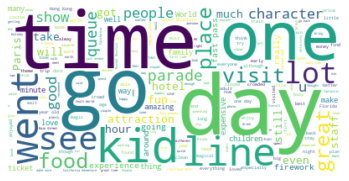

In [14]:
### Generate word clouds 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

stopwords = set(STOPWORDS)
stopwords.update(["park", "parks","ride","rides", "Disney", "Disneyland"])

### General word cloud

text = " ".join(review for review in disneyland.Review_Text)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



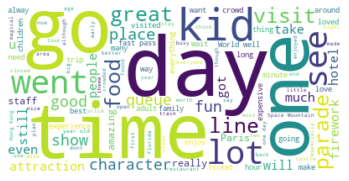

In [15]:
### Positive word cloud
pos = " ".join(review for review in positive.Review_Text)
wordcloud1 = WordCloud(stopwords=stopwords, background_color="white").generate(pos)

plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()


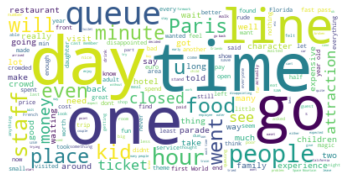

In [16]:
### negative word cloud
neg = " ".join(review for review in negative.Review_Text)
wordcloud2 = WordCloud(stopwords=stopwords, background_color="white").generate(neg)

plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
### Transform review text with CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(disneyland['Review_Text'])

In [26]:
### Set train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    text_counts, disneyland['sentiment'], test_size=0.3, random_state=1)

In [27]:
### Train a Multinomial Naive Bayesian model and find accuracy with test data
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.9431868619618287


In [28]:
### Train a Multinomial Naive Bayesian model using tf-idf
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
text_tf = tfidf_transformer.fit_transform(text_counts)


In [29]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    text_tf, disneyland['sentiment'], test_size=0.3, random_state=8)

In [30]:
clf2 = MultinomialNB().fit(X_train2, y_train2)
predicted2= clf2.predict(X_test2)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test2, predicted2))

MultinomialNB Accuracy: 0.9032401242787395


In [63]:
### Test model with two random Disneyland reviews from Google reviews (one positive, one negative)
new_review = ["I grew up going to Disneyland my whole life! Now at 60 years of age I see the prices and it is actually very sad!! I go on the computer to purchase a ticket for the So Ca deal. What a joke!! Such greed! I would like to go one day, not two, not three! I wanted one day only. Please rethink to have a So Cal day not days. The price is ridiculously expensive!!!", "The most magical place in the world. They treat their handicapped guests with dignity and respect. The ride are amazing. They have something for everyone. Food is excellent. Fantastic for family vacation. I have been going  to Disneyland since 1965. This time was with my daughter and granddaughters."]
X_new_counts = cv.transform(new_review)
predicted3 = clf.predict(X_new_counts)


In [64]:
for review, sentiment in zip(new_review, predicted3):
    print('%r => %s' % (review, sentiment))


'I grew up going to Disneyland my whole life! Now at 60 years of age I see the prices and it is actually very sad!! I go on the computer to purchase a ticket for the So Ca deal. What a joke!! Such greed! I would like to go one day, not two, not three! I wanted one day only. Please rethink to have a So Cal day not days. The price is ridiculously expensive!!!' => 0
'The most magical place in the world. They treat their handicapped guests with dignity and respect. The ride are amazing. They have something for everyone. Food is excellent. Fantastic for family vacation. I have been going  to Disneyland since 1965. This time was with my daughter and granddaughters.' => 1
